# Technical setup
> Skip this section

In [24]:
# @formatter:off

In [25]:
%%time
%reload_ext autoreload
%autoreload 2
# @formatter:on

CPU times: user 5 ms, sys: 8.32 ms, total: 13.3 ms
Wall time: 13.3 ms


# Parameters

In [26]:
symbol = 'ETHUSDT'
symbol_k_lines_interval = '1s'
symbol_ask_bid_price_difference = 0.01
price_step_ratio = 0.001

# Ticks

/Users/nikita/Documents/projects/things-team/to-the-moon/ttm-analytics/src/chart/ttm_chart.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  plot.set_xticklabels(plot.get_xticklabels(), rotation=60)


,timestamp,bid_price,ask_price
0,1677628800000,1605.24,1605.25
1,1677628801000,1605.46,1605.47
2,1677628802000,1605.46,1605.47
3,1677628803000,1605.46,1605.47
4,1677628804000,1605.47,1605.48
...,...,...,...
86395,1681775995000,2074.00,2074.01
86396,1681775996000,2074.00,2074.01
86397,1681775997000,2074.00,2074.01
86398,1681775998000,2074.00,2074.01


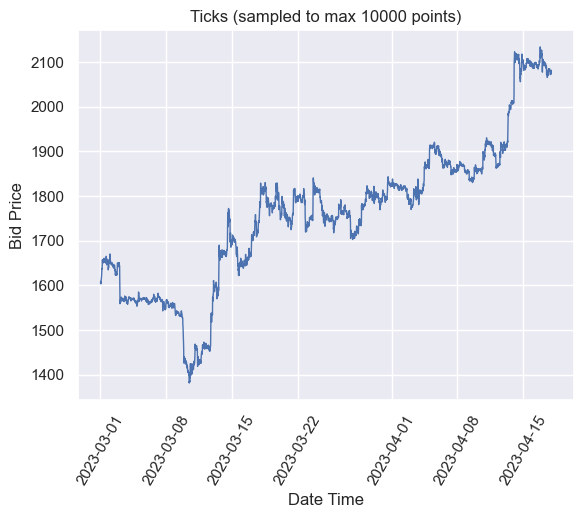

In [27]:
from IPython.core.display_functions import display

from binance.binance_k_line_loader import load_binance_k_lines
from binance.binance_tick_loader import load_binance_ticks
from chart.ttm_chart import draw_line_chart

k_lines = load_binance_k_lines(f"../../../ttm-data/{symbol}-{symbol_k_lines_interval}-*.csv")

ticks = load_binance_ticks(k_lines, symbol_ask_bid_price_difference)

draw_line_chart(ticks, 'timestamp', 'bid_price', 'Bid Price', 'Ticks')

display(ticks)

# Simulation Setup

In [28]:
# @formatter:off

In [29]:
%%time
# @formatter:on

from trade.trade_simulator import TradeSimulator

trade_simulator: TradeSimulator = TradeSimulator(ticks)

CPU times: user 51.6 s, sys: 1.02 s, total: 52.6 s
Wall time: 52.9 s


# Simulation


    Closed orders count: 30049
    Cumulative profit: -1199.560000000114



/Users/nikita/Documents/projects/things-team/to-the-moon/ttm-analytics/src/chart/ttm_chart.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  plot.set_xticklabels(plot.get_xticklabels(), rotation=60)


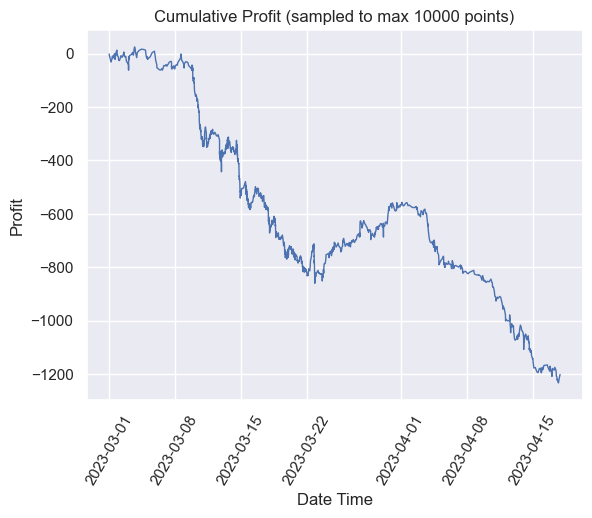

In [30]:
from trade.trade_simulator_order_type import TradeSimulatorOrderType
from trade.trade_simulator_order import TradeSimulatorOrder
from trade.trade_simulator_tick import TradeSimulatorTick
from trade.trade_simulator_strategy import TradeSimulatorStrategy


class Strategy1(TradeSimulatorStrategy):
    check_point_tick: TradeSimulatorTick | None

    def __init__(self) -> None:
        super().__init__()
        self.check_point_tick = None

    def process_tick(self, new_tick: TradeSimulatorTick,
                     orders: [TradeSimulatorOrder], closed_orders: [TradeSimulatorOrder]):
        if self.check_point_tick is None:
            self.check_point_tick = new_tick
            # print(f"Initial checkpoint set at {tick.get_date_time()} and bid price: {tick.bid_price}")

        elif self.is_growth_step(new_tick):
            orders.append(TradeSimulatorOrder(new_tick, TradeSimulatorOrderType.SELL, price_step_ratio))
            self.check_point_tick = new_tick

        elif self.is_failing_step(new_tick):
            orders.append(TradeSimulatorOrder(new_tick, TradeSimulatorOrderType.BUY, price_step_ratio))
            self.check_point_tick = new_tick

    def is_growth_step(self, new_tick: TradeSimulatorTick):
        return (new_tick.bid_price >=
                self.check_point_tick.ask_price + self.check_point_tick.ask_price * price_step_ratio)

    def is_failing_step(self, new_tick: TradeSimulatorTick):
        return (new_tick.ask_price <=
                self.check_point_tick.bid_price - self.check_point_tick.bid_price * price_step_ratio)


trade_simulator.simulate(Strategy1())

# ============
# Closed orders count: 30049
# Cumulative profit: -1199.560000000114
# ============
print(f"""
    ============
    Closed orders count: {len(trade_simulator.closed_orders)}
    Cumulative profit: {trade_simulator.get_cumulative_profit()}
    ============
""")

profits = trade_simulator.get_profits()

draw_line_chart(profits, 'open_timestamp', 'cumulative_profit', 'Profit', 'Cumulative Profit')

# display(profits)